# Sentiment Analysis Starter Code
Use this code as a template, starting place, or inspiration... whatever helps you get started!

## Imports
This starter code will be using the following packages:
- `Pandas`
- `NumPy`
- `PyTorch`
- `nltk`
Be sure to install these using either `pip` or `conda`!

In [1]:
import pandas as pd
import os
import numpy as np
import nltk
nltk.download('punkt')
import torch

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\natha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
c:\Users\natha\anaconda3\envs\nlp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Downloading Data
Visit [https://www.kaggle.com/competitions/osuaiclub-fall2022-nlp-challenge/data](https://www.kaggle.com/competitions/osuaiclub-fall2022-nlp-challenge/data) to download the dataset!

## Loading Data
We will be using the `pandas` package to load in our data. All the data is conveniently stored in a `.csv` file which is really easy to construct a `pandas` dataframe out of.

In [2]:
DATA_DIR = './data/'

In [3]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'), index_col='id')
train_df

,text,sentiment
id,,
0,"""2nd day on 5mg started to work with rock hard...",0
1,"""He pulled out, but he cummed a bit in me. I t...",0
2,""" I Ve had nothing but problems with the Kepp...",0
3,"""I had Crohn's with a resection 30 years ago a...",0
4,"""Have a little bit of a lingering cough from a...",0
...,...,...
999995,Awful awful awful. Length. Came to top of wa...,0
999996,VERY SMALL. COULDN'T USE AS GIFT AS INTENDED.,0
999997,"Very thin material. Good for summer, spring an...",0


## Using Subset of Dataset for Quicker Experimentation
We recommend using and triaining on a small subset of the dataset while you are prototyping and trying to get your model to work.

In [4]:
# Calculate the size of the dataset
num_samples = len(train_df.index)

# Define how many samples we want in our smaller dataset
target_num_samples = 1000

# Calculate how many training samples we need to remove
n_remove = num_samples - target_num_samples

# Randomly choose the n_remove indices we will remove
drop_indices = np.random.choice(train_df.index, n_remove, replace=False)
train_df = train_df.drop(drop_indices)

# Show the remaining dataframe
train_df

,text,sentiment
id,,
304,"""Took this for the first time today for a migr...",0
3419,"""Insomnia for years. Prescibed temazepam out o...",0
3658,"""Pros: \n\n-no more acne, just the occasional ...",0
4892,"""It works.. but my period was all over the pla...",0
6304,"""If you have a really bad infection then don'...",0
...,...,...
994504,I'm very happi with it! :),1
995918,"I Received a diferente number of shoes, doesnt...",0
996044,"At first, they felt somewhat narrow, but the n...",1


## Fix Class Imbalance in Dataset
This dataset heavily favors the `1` sentiment, which represents a positive sentiment. This results in there being significantly more positive training samples than there are negative training samples.

In [5]:
train_df['sentiment'].value_counts()

1    623
0    377
Name: sentiment, dtype: int64

For simplicity, we will address this imbalance with [undersampling](https://machinelearningmastery.com/undersampling-algorithms-for-imbalanced-classification/) by reducing the number of positive sentiment samples in the dataset at random until it matches the number of negative sentiment samples.

In [6]:
# Define values for positive and negative sentiment
POSITIVE_SENTIMENT = 1
NEGATIVE_SENTIMENT = 0

# Count the number of positive and negative samples
num_pos_samples = train_df['sentiment'].value_counts()[POSITIVE_SENTIMENT] 
num_neg_samples = train_df['sentiment'].value_counts()[NEGATIVE_SENTIMENT]

# Calculate the number of positive samples we need to remove to have 
# the same number as negative samples 
num_pos_remove = num_pos_samples - num_neg_samples

In [7]:
# Split the Dataset into Dataframes of Postive and Negative Only Samples
pos_df = train_df[train_df['sentiment'] == POSITIVE_SENTIMENT]
neg_df = train_df[train_df['sentiment'] == NEGATIVE_SENTIMENT]

# Randomly caluclate the postive dataframe indeces to remove
pos_drop_indices = np.random.choice(pos_df.index, num_pos_remove, replace=False)

# Drop Selected Samples from the Positive Dataframe to balance out both sentiment values
pos_undersampled = pos_df.drop(pos_drop_indices)
pos_undersampled

,text,sentiment
id,,
12746,"""I just wanted to share my experience to hopef...",1
21615,"""I have used Motofen for over 5 years for the ...",1
27391,"""I just got my mirena inserted yesterday and s...",1
30844,"""I started taking phentermine on 9/28/15 and w...",1
35512,"""An 80 mg oxycodone ER tablet should be reserv...",1
...,...,...
988173,Pants fit really good just had to shorten the ...,1
990069,Good quality and fit perfectly,1
996044,"At first, they felt somewhat narrow, but the n...",1


In [8]:
# Combine the negative samples and the positive samples into one dataframe
balanced_train_df = pd.concat([neg_df, pos_undersampled])

# Check the counts to make sure the classes are now even
balanced_train_df['sentiment'].value_counts()

0    377
1    377
Name: sentiment, dtype: int64

In [9]:
balanced_train_df.to_csv(os.path.join(DATA_DIR, 'all_sets.csv'))

TOTAL_SAMPLES = balanced_train_df.shape[0]
TOTAL_SAMPLES

754

## Data Preprocessing
Now that we have created the training and testing split for our data, we can use techniques like tokenization to make the dataset easier for our model to process and train on. We will only be showing how to apply tokenization, but we encourage you to try other techniques!

We will be using the PyTorch torchtext libary to achieve this.

### Creating a "Vocabulary"
Next, we need to create a "vocabulary" of all words in the dataset. In NLP, a vocabulary is the mapping of each word to a unique ID. We will represent words in numerical form for the model to be able to interpret them.

By creating this mapping, one can write a sentence with numbers. For instance, if the vocab is as follows:

```python
{
  "i": 0,
 "the": 1,
 "ate": 2,
 "pizza": 3
}
```

We can say "I ate the pizza" by saying `[0, 2, 1, 3]`.

This is an oversimplified explanation of encoding, but the general idea is the same.


`<START>` and `<END>` represent the start and end of the sample respectively. They are tokens used to identify the beginning and ending of each sentence in order to train the model. As shown, they will be inserted at the beginning and end of each sample.

`<UNK>` is the token used to represent any word not in our vocabulary. This is most useful when you want to limit the vocabulary size to increase the speed of training or run inference on text never seen before. 

## Build Data Processing Pipelines

In [10]:
from torchtext.data.utils import get_tokenizer
from collections import Counter, OrderedDict
from torchtext.vocab import vocab

tokenizer = get_tokenizer('basic_english')
counter = Counter()

for (_,text, sentiment) in list(pd.read_csv(os.path.join(DATA_DIR,'all_sets.csv')).itertuples(index=False, name=None)):
    tokenized = tokenizer(text)
    counter.update(tokenized)
    
sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[1], reverse=True)
ordered_dict = OrderedDict(sorted_by_freq_tuples)
vocab = vocab(counter, min_freq = 10, specials=('<UNK>', '<START>', '<END>', '<PAD>'))

In [11]:
def vocab_token(token):
    if token in vocab:
        return vocab[token]
    else:
        return vocab['<UNK>']

In [12]:
[vocab_token(token) for token in "this is an".split()]

[5, 76, 164]

In [13]:
vocab['<PAD>']

3

In [14]:
def text_pipeline(x):
    return [vocab_token(token) for token in tokenizer(x)]
    
    
def label_pipline(y):
    return int(y)

In [15]:
text_pipeline('here is an example')

[387, 76, 164, 0]

## Create dataset object

In [16]:
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence

PAD_IDX = vocab['<PAD>']
START_IDX = vocab['<START>']
END_IDX = vocab['<END>']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SentimentDataset(Dataset):
    
    def process_input(self, sample):
        _, _text, _label = sample
        label = torch.tensor([label_pipline(_label)], dtype=torch.int32)
        text = torch.tensor([START_IDX] + text_pipeline(_text) + [END_IDX], dtype=torch.int32)
        return text, label
    
    def __init__(self, csv_file_path):
        self.data = list(pd.read_csv(csv_file_path).itertuples(index=False, name=None))
        self.processed_data = [self.process_input(x) for x in self.data]
        self.inpts = pad_sequence([x for x, _ in self.processed_data], batch_first=True, padding_value=PAD_IDX)
        self.labels = [y for _, y in self.processed_data]
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.inpts[idx].to(device), self.labels[idx].to(device)

C:\Users\natha\AppData\Local\Temp\ipykernel_12284\84592848.py:8: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:68.)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [17]:
dataset = SentimentDataset(os.path.join(DATA_DIR, 'all_sets.csv'))

## Generate DataLoader Object

In [18]:
import math 

BATCH_SIZE = 64

train_ratio = 0.85
val_ratio = 0.15

train_counts = math.ceil(len(dataset) * train_ratio)
val_counts = len(dataset) - train_counts

print(train_counts, val_counts)

641 113


In [19]:
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader

train_ds, val_ds = random_split(dataset, [train_counts, val_counts])
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

## Define the Model
Now we can create a model and train it!

In [20]:
from torch import nn 

class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [21]:
no_layers = 2
vocab_size = len(vocab)
embedding_dim = 400
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(549, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


## Train the Model
https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/1%20-%20Simple%20Sentiment%20Analysis.ipynb

In [22]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [23]:
clip = 5
epochs = 100
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

if os.path.exists('./models/state_dict.pt'):
    print("Loading existing model...")
    # model.load_state_dict(torch.load('./models/state_dict.pt'))

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(BATCH_SIZE)
    for inputs, labels in train_dl:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float().squeeze())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(BATCH_SIZE)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in val_dl:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float().squeeze())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_dl.dataset)
    epoch_val_acc = val_acc/len(val_dl.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}/{epochs}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), './models/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

Loading existing model...
Epoch 1/100
train_loss : 0.7130982637405395 val_loss : 0.6931478977203369
train_accuracy : 47.269890795631824 val_accuracy : 28.31858407079646
Validation loss decreased (inf --> 0.693148).  Saving model ...
Epoch 2/100
train_loss : 0.6962253034114838 val_loss : 0.6988776922225952
train_accuracy : 51.014040561622465 val_accuracy : 25.663716814159294
Epoch 3/100
train_loss : 0.6938348233699798 val_loss : 0.6900608539581299
train_accuracy : 48.985959438377535 val_accuracy : 33.6283185840708
Validation loss decreased (0.693148 --> 0.690061).  Saving model ...
Epoch 4/100
train_loss : 0.694170743227005 val_loss : 0.6957467794418335
train_accuracy : 50.078003120124805 val_accuracy : 24.778761061946902
Epoch 5/100
train_loss : 0.6934852004051208 val_loss : 0.6934345364570618
train_accuracy : 49.453978159126365 val_accuracy : 27.43362831858407
Epoch 6/100
train_loss : 0.6932817935943604 val_loss : 0.6932986378669739
train_accuracy : 50.23400936037441 val_accuracy : 28

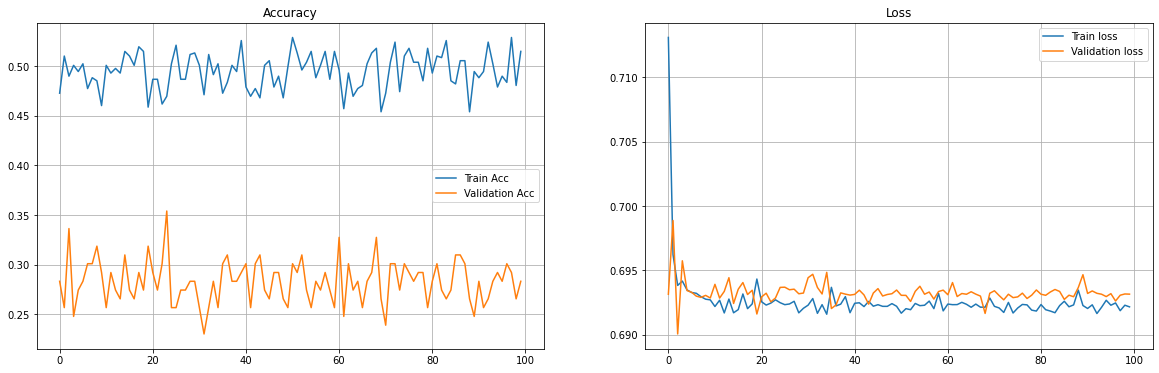

In [24]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

## Inference On Test Dataset

In [25]:
inference_model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)
inference_model.load_state_dict(torch.load('./models/state_dict.pt'))
inference_model.eval()
inference_model.to(device)

SentimentRNN(
  (embedding): Embedding(549, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [26]:
def inference(model, text):
    text_tensor = torch.tensor([START_IDX] + text_pipeline(text) + [END_IDX], dtype=torch.int32).to(device).unsqueeze(0)
    batch_size = 1
    h = model.init_hidden(batch_size)
    h = tuple([x.data for x in h])
    output, h = model(text_tensor, h)
    prediction = output.item()
    return 1 if prediction > 0.5 else 0

In [27]:
from tqdm import tqdm

predictions = [] # {id,prediction}

for id_, text in tqdm(list(pd.read_csv(os.path.join(DATA_DIR, 'test.csv'), index_col='id').itertuples(index=True, name=None))):
    prediction = inference(model, text)
    predictions.append({'id': id_, 'sentiment': prediction})

    
preds = pd.DataFrame(predictions)
preds.to_csv('submission.csv', index=False)
preds

100%|██████████| 250000/250000 [15:53<00:00, 262.16it/s]


,id,sentiment
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
249995,249995,1
249996,249996,1
249997,249997,1
249998,249998,1
